C:\Users\yueli\AppData\Local\Temp\ipykernel_5392\4213442076.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Loaded dist_head state_dict.


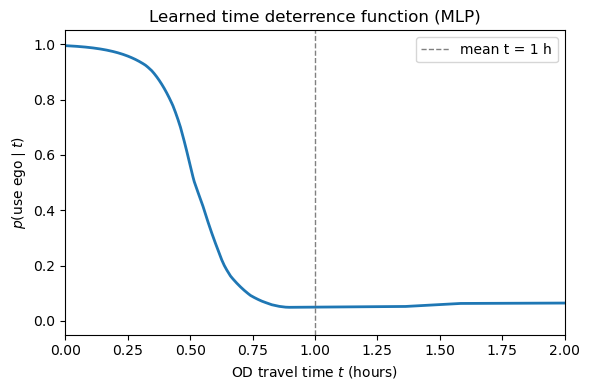

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# 1. Config: paths & shapes
# ==========================
ckpt_path = "../param/cv_0/best_stage_1_lr1e-03.pt"  # <-- update if needed

# time normalization (must match training)
T_MEAN = 3600.0
T_STD  = 1000.0

# hidden sizes for the time-MLP (must match MODEL["t_hidden"])
T_HIDDEN = [16, 16]

# range of t to visualize (in seconds)
T_MIN = 0.0
T_MAX = 7200.0
N_POINTS = 400


# ==========================
# 2. Rebuild deterrence MLP
# ==========================
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.1, act=nn.ReLU):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), act(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class DistanceProbMLP(nn.Module):
    """
    p(use ego | t) = sigmoid( MLP( (t - mu) / s ) )
    where t is in seconds, mu=3600, s=1000 in your config.
    """
    def __init__(self, t_mean=T_MEAN, t_std=T_STD, hidden=T_HIDDEN):
        super().__init__()
        self.register_buffer("mu", torch.tensor(t_mean, dtype=torch.float32))
        self.register_buffer("s",  torch.tensor(t_std,  dtype=torch.float32))
        self.mlp = MLP(1, hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, d: torch.Tensor) -> torch.Tensor:
        # d: [N] (float, seconds)
        d_norm = (d - self.mu) / (self.s.abs() + 1e-6)
        d_norm = d_norm.view(-1, 1)  # [N,1]
        logits = self.mlp(d_norm).squeeze(-1)  # [N]
        return self.sigmoid(logits)            # [N]


# ==========================
# 3. Load checkpoint & extract dist_head weights
# ==========================
ckpt = torch.load(ckpt_path, map_location="cpu")
state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

# instantiate local copy of the deterrence module
dist_head = DistanceProbMLP()
dist_state = {}

# copy over only keys that belong to dist_head.*
for k, v in state_dict.items():
    if k.startswith("dist_head."):
        subkey = k.replace("dist_head.", "")
        dist_state[subkey] = v

missing, unexpected = dist_head.load_state_dict(dist_state, strict=False)
print("Loaded dist_head state_dict.")
if missing:
    print("  Missing keys:", missing)
if unexpected:
    print("  Unexpected keys:", unexpected)

dist_head.eval()


# ==========================
# 4. Build t-grid and compute probabilities
# ==========================
t_grid = torch.linspace(T_MIN, T_MAX, N_POINTS)  # seconds
with torch.no_grad():
    p_grid = dist_head(t_grid).numpy()

t_grid_np = t_grid.numpy()

# ==========================
# 5. Plot
# ==========================
plt.figure(figsize=(6,4))
plt.plot(t_grid_np / 3600.0, p_grid, lw=2)  # convert x to hours for readability
plt.axvline(T_MEAN / 3600.0, color="grey", ls="--", lw=1, label="mean t = 1 h")
plt.xlabel("OD travel time $t$ (hours)")
plt.ylabel("$p(\\text{use ego} \\mid t)$")
plt.title("Learned time deterrence function (MLP)")
plt.ylim(-0.05, 1.05)
plt.xlim(T_MIN / 3600.0, T_MAX / 3600.0)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
#!/usr/bin/env python3
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Config
# ==========================
# If you truly have 9 region-specific checkpoints, set this to cv_{k} with k=1..9.
# If you still only have cv_0..cv_4, either:
#   (a) change N_FOLDS = 5 and REGION_CODES accordingly, or
#   (b) point CKPT_TEMPLATE to your region-specific dirs.
CKPT_TEMPLATE = "../param/spatial_cv_{k}/best_stage_1_lr1e-03.pt"  # k=1..9 (region 1..9)

T_MEAN = 3600.0
T_STD  = 1000.0
T_HIDDEN = [16, 16]

T_MIN = 0.0
T_MAX = 7200.0
N_POINTS = 400

OUT_FIG = "time_deterrence_by_region.svg"
VLINES_MIN = [15, 30, 45, 60]  # minutes

# 1..9 correspond to region codes (as you stated)
REGION_CODES = [
    "E12000001", "E12000002", "E12000003", "E12000004", "E12000005",
    "E12000006", "E12000007", "E12000008", "E12000009"
]

# Your palette (9 colors)
REGION_COLORS = [
    "#d53e4f",
    "#f46d43",
    "#fdae61",
    "#fee08b",
    "#ffffbf",
    "#e6f598",
    "#abdda4",
    "#66c2a5",
    "#3288bd",
]

# Optional: nicer legend labels
REGION_NAMES = {
    "E12000001": "North East",
    "E12000002": "North West",
    "E12000003": "Yorkshire & The Humber",
    "E12000004": "East Midlands",
    "E12000005": "West Midlands",
    "E12000006": "East of England",
    "E12000007": "London",
    "E12000008": "South East",
    "E12000009": "South West",
}

# ==========================
# Model defs (must match training)
# ==========================
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.1, act=nn.ReLU):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), act(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class DistanceProbMLP(nn.Module):
    """
    p(use ego | t) = sigmoid( MLP( (t - mu) / s ) )
    """
    def __init__(self, t_mean=T_MEAN, t_std=T_STD, hidden=T_HIDDEN):
        super().__init__()
        self.register_buffer("mu", torch.tensor(t_mean, dtype=torch.float32))
        self.register_buffer("s",  torch.tensor(t_std,  dtype=torch.float32))
        self.mlp = MLP(1, hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, d: torch.Tensor) -> torch.Tensor:
        d_norm = (d - self.mu) / (self.s.abs() + 1e-6)
        d_norm = d_norm.view(-1, 1)
        logits = self.mlp(d_norm).squeeze(-1)
        return self.sigmoid(logits)

def load_dist_head_from_ckpt(ckpt_path: str) -> DistanceProbMLP:
    ckpt = torch.load(ckpt_path, map_location="cpu")
    state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    dist_head = DistanceProbMLP()
    dist_state = {}
    for k, v in state_dict.items():
        if k.startswith("dist_head."):
            dist_state[k.replace("dist_head.", "")] = v

    missing, unexpected = dist_head.load_state_dict(dist_state, strict=False)
    if missing:
        print(f"[WARN] {os.path.basename(ckpt_path)} missing keys: {missing}")
    if unexpected:
        print(f"[WARN] {os.path.basename(ckpt_path)} unexpected keys: {unexpected}")

    dist_head.eval()
    return dist_head

# ==========================
# Compute & plot per region
# ==========================
t_grid = torch.linspace(T_MIN, T_MAX, N_POINTS)  # seconds
t_min_np = (t_grid.numpy() / 60.0).astype(float)  # minutes

plt.figure(figsize=(7.0, 4.6))

for idx, (code, col) in enumerate(zip(REGION_CODES, REGION_COLORS), start=1):
    ckpt_path = CKPT_TEMPLATE.format(k=idx)  # k=1..9
    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    print("[Load]", ckpt_path)
    dist_head = load_dist_head_from_ckpt(ckpt_path)

    with torch.no_grad():
        p = dist_head(t_grid).numpy().astype(float)

    label = f"{REGION_NAMES.get(code, code)} ({code})"
    plt.plot(t_min_np, p, lw=2, color=col, label=label)

for m in VLINES_MIN:
    plt.axvline(m, color="grey", ls="--", lw=1)

plt.xlabel("OD travel time $t$ (minutes)")
plt.ylabel("$p(\\mathrm{use\\ ego}\\mid t)$")
plt.ylim(0.0, 1.0)
plt.xlim(T_MIN/60.0, T_MAX/60.0)
plt.legend(frameon=False, fontsize=8, ncol=1)
plt.tight_layout()
plt.savefig(OUT_FIG, bbox_inches="tight")
plt.close()

print("[Save]", OUT_FIG)

[Load] ../param/spatial_cv_1/best_stage_1_lr1e-03.pt
[Load] ../param/spatial_cv_2/best_stage_1_lr1e-03.pt
[Load] ../param/spatial_cv_3/best_stage_1_lr1e-03.pt
[Load] ../param/spatial_cv_4/best_stage_1_lr1e-03.pt
[Load] ../param/spatial_cv_5/best_stage_1_lr1e-03.pt
[Load] ../param/spatial_cv_6/best_stage_1_lr1e-03.pt
[Load] ../param/spatial_cv_7/best_stage_1_lr1e-03.pt
[Load] ../param/spatial_cv_8/best_stage_1_lr1e-03.pt
[Load] ../param/spatial_cv_9/best_stage_1_lr1e-03.pt
[Save] time_deterrence_by_region.svg


C:\Users\yueli\AppData\Local\Temp\ipykernel_40220\2441542032.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


In [7]:
#!/usr/bin/env python3
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Config
# ==========================
CKPT_TEMPLATE = "../param/cv_{k}/best_stage_1_lr1e-03.pt"  # cv_0..cv_4

T_MEAN = 3600.0
T_STD  = 1000.0
T_HIDDEN = [16, 16]

T_MIN = 0.0
T_MAX = 7200.0
N_POINTS = 500

OUT_FIG = "time_deterrence_random.svg"

# vertical markers (minutes)
VLINES_MIN = [15, 30, 45, 60]

# style
MARK_COLOR = (214/255, 39/255, 40/255)  # red
MARK_LW = 1.2
MARK_LS = ":"

FIGSIZE = (8.0, 4.0)

# ==========================
# Model defs (must match training)
# ==========================
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.1, act=nn.ReLU):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), act(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class DistanceProbMLP(nn.Module):
    """
    p(use ego | t) = sigmoid( MLP( (t - mu) / s ) )
    """
    def __init__(self, t_mean=T_MEAN, t_std=T_STD, hidden=T_HIDDEN):
        super().__init__()
        self.register_buffer("mu", torch.tensor(t_mean, dtype=torch.float32))
        self.register_buffer("s",  torch.tensor(t_std,  dtype=torch.float32))
        self.mlp = MLP(1, hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, d: torch.Tensor) -> torch.Tensor:
        d_norm = (d - self.mu) / (self.s.abs() + 1e-6)
        d_norm = d_norm.view(-1, 1)
        logits = self.mlp(d_norm).squeeze(-1)
        return self.sigmoid(logits)

def load_dist_head_from_ckpt(ckpt_path: str) -> DistanceProbMLP:
    ckpt = torch.load(ckpt_path, map_location="cpu")
    state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    dist_head = DistanceProbMLP()
    dist_state = {}
    for k, v in state_dict.items():
        if k.startswith("dist_head."):
            dist_state[k.replace("dist_head.", "")] = v

    missing, unexpected = dist_head.load_state_dict(dist_state, strict=False)
    if missing:
        print(f"[WARN] {os.path.basename(ckpt_path)} missing keys: {missing}")
    if unexpected:
        print(f"[WARN] {os.path.basename(ckpt_path)} unexpected keys: {unexpected}")

    dist_head.eval()
    return dist_head

# ==========================
# Compute curves per fold
# ==========================
t_grid = torch.linspace(T_MIN, T_MAX, N_POINTS)                # seconds
t_min_np = (t_grid.numpy() / 60.0).astype(float)              # minutes

curves = []
for k in range(5):
    ckpt_path = CKPT_TEMPLATE.format(k=k)
    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    print("[Load]", ckpt_path)

    dist_head = load_dist_head_from_ckpt(ckpt_path)
    with torch.no_grad():
        p = dist_head(t_grid).numpy().astype(float)            # (N_POINTS,)
    curves.append(p)

curves = np.vstack(curves)                                     # (5, N_POINTS)
p_mean = curves.mean(axis=0)                                   # (N_POINTS,)
p_min  = curves.min(axis=0)
p_max  = curves.max(axis=0)

# ==========================
# Plot: mean + range
# ==========================
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(t_min_np, p_mean, lw=2, label="Mean (5 folds)")
ax.fill_between(t_min_np, p_min, p_max, alpha=0.25, label="Range across folds")

# helper: y on mean curve at given minute (linear interpolation)
def y_at_minute(minute: float) -> float:
    return float(np.interp(minute, t_min_np, p_mean))

# markers: truncated vlines/hlines + value labels


for m in VLINES_MIN:
    yv = y_at_minute(m)

    # vertical dotted line only from y=0 up to the curve
    ax.vlines(m, 0.0, yv, colors=[MARK_COLOR], linestyles=MARK_LS, linewidth=MARK_LW)

    # horizontal dotted line only from y-axis to the curve (x from 0 to m)
    ax.hlines(yv, 0.0, m if m != 60 else 120, colors=[MARK_COLOR], linestyles=MARK_LS, linewidth=MARK_LW)


    # label at y-axis (slightly left of axis; don't clip)
    offset = 0.015 if yv > 0.95 else 0.0
    ax.text(
        -1.0, yv - offset, f"{yv:.2f}",
        color=MARK_COLOR, va="center", ha="right", fontsize=9, clip_on=False
    )

# axes styling
ax.set_xlabel("OD travel time $t_{od}$ (minutes)")
ax.set_ylabel("Actual-to-potential flow ratio $p_{od}$")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(T_MIN/60.0, T_MAX/60.0)

# x ticks every 15 minutes
xticks = np.arange(0, int(T_MAX/60.0) + 1, 15)
ax.set_xticks(xticks)

ax.legend(frameon=False)
fig.tight_layout()

fig.savefig(OUT_FIG, bbox_inches="tight")
plt.close(fig)

print("[Save]", OUT_FIG)

[Load] ../param/cv_0/best_stage_1_lr1e-03.pt
[Load] ../param/cv_1/best_stage_1_lr1e-03.pt
[Load] ../param/cv_2/best_stage_1_lr1e-03.pt
[Load] ../param/cv_3/best_stage_1_lr1e-03.pt
[Load] ../param/cv_4/best_stage_1_lr1e-03.pt
[Save] time_deterrence_random.svg


C:\Users\yueli\AppData\Local\Temp\ipykernel_7996\2556128118.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


In [5]:
#!/usr/bin/env python3
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ==========================
# Config
# ==========================
# Random CV (cv_0..cv_4) used to compute reference mean curve
CKPT_TEMPLATE_RAND = "../param/cv_{k}/best_stage_1_lr1e-03.pt"          # k=0..4
N_RAND_FOLDS = 5

# Region-specific checkpoints (spatial_cv_1..spatial_cv_9)
CKPT_TEMPLATE_REGION = "../param/spatial_cv_{k}/best_stage_1_lr1e-03.pt"  # k=1..9

T_MEAN = 3600.0
T_STD  = 1000.0
T_HIDDEN = [16, 16]

T_MIN = 0.0
T_MAX = 7200.0
N_POINTS = 400

# Output
OUT_DIR = Path("t_deterrence")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# size of each svg
FIGSIZE = (2.8, 2.5)

# Reference line style (random-CV mean)
REF_COLOR = "grey"
REF_LS = ":"
REF_LW = 1.6

# Region curve style
REG_LW = 2.0

# Region codes (k=1..9)
REGION_CODES = [
    "E12000001", "E12000002", "E12000003", "E12000004", "E12000005",
    "E12000006", "E12000007", "E12000008", "E12000009"
]

# Your palette (9 colors)
REGION_COLORS = [
    "#d53e4f",
    "#f46d43",
    "#fdae61",
    "#fee08b",
    "#ffffbf",
    "#e6f598",
    "#abdda4",
    "#66c2a5",
    "#3288bd",
]

# Legend labels (no region code in legend)
REGION_NAMES = {
    "E12000001": "North East",
    "E12000002": "North West",
    "E12000003": "Yorkshire & The Humber",
    "E12000004": "East Midlands",
    "E12000005": "West Midlands",
    "E12000006": "East of England",
    "E12000007": "London",
    "E12000008": "South East",
    "E12000009": "South West",
}

# ==========================
# Model defs (must match training)
# ==========================
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.1, act=nn.ReLU):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), act(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class DistanceProbMLP(nn.Module):
    """
    p(use ego | t) = sigmoid( MLP( (t - mu) / s ) )
    """
    def __init__(self, t_mean=T_MEAN, t_std=T_STD, hidden=T_HIDDEN):
        super().__init__()
        self.register_buffer("mu", torch.tensor(t_mean, dtype=torch.float32))
        self.register_buffer("s",  torch.tensor(t_std,  dtype=torch.float32))
        self.mlp = MLP(1, hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, d: torch.Tensor) -> torch.Tensor:
        d_norm = (d - self.mu) / (self.s.abs() + 1e-6)
        d_norm = d_norm.view(-1, 1)
        logits = self.mlp(d_norm).squeeze(-1)
        return self.sigmoid(logits)

def load_dist_head_from_ckpt(ckpt_path: str) -> DistanceProbMLP:
    ckpt = torch.load(ckpt_path, map_location="cpu")
    state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    dist_head = DistanceProbMLP()
    dist_state = {}
    for k, v in state_dict.items():
        if k.startswith("dist_head."):
            dist_state[k.replace("dist_head.", "")] = v

    missing, unexpected = dist_head.load_state_dict(dist_state, strict=False)
    if missing:
        print(f"[WARN] {os.path.basename(ckpt_path)} missing keys: {missing}")
    if unexpected:
        print(f"[WARN] {os.path.basename(ckpt_path)} unexpected keys: {unexpected}")

    dist_head.eval()
    return dist_head

# ==========================
# Compute reference mean curve (random CV)
# ==========================
t_grid = torch.linspace(T_MIN, T_MAX, N_POINTS)               # seconds
t_min_np = (t_grid.numpy() / 60.0).astype(float)             # minutes

rand_curves = []
for k in range(N_RAND_FOLDS):
    ckpt_path = CKPT_TEMPLATE_RAND.format(k=k)
    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(f"Random CV checkpoint not found: {ckpt_path}")
    print("[Load rand]", ckpt_path)

    dist_head = load_dist_head_from_ckpt(ckpt_path)
    with torch.no_grad():
        p = dist_head(t_grid).numpy().astype(float)
    rand_curves.append(p)

rand_curves = np.vstack(rand_curves)                          # (5, N_POINTS)
p_ref_mean = rand_curves.mean(axis=0)                          # (N_POINTS,)

# ==========================
# Plot per region (9 separate SVGs)
# ==========================
for idx, (code, col) in enumerate(zip(REGION_CODES, REGION_COLORS), start=1):
    ckpt_path = CKPT_TEMPLATE_REGION.format(k=idx)            # k=1..9
    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(f"Region checkpoint not found: {ckpt_path}")

    print("[Load region]", ckpt_path)
    dist_head = load_dist_head_from_ckpt(ckpt_path)

    with torch.no_grad():
        p_reg = dist_head(t_grid).numpy().astype(float)

    region_name = REGION_NAMES.get(code, code)
    out_svg = OUT_DIR / f"time_deterrence_{region_name.replace(' ', '_').replace('&','and')}.svg"

    fig, ax = plt.subplots(figsize=FIGSIZE)

    # region curve
    ax.plot(t_min_np, p_reg, lw=REG_LW, color=col, label=region_name)

    # reference mean (random CV)
    ax.plot(t_min_np, p_ref_mean, lw=REF_LW, color=REF_COLOR, ls=REF_LS, label="Random CV mean")

    # axes styling (no titles)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlim(T_MIN/60.0, T_MAX/60.0)

    # remove axis titles (keep ticks)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # tidy
    ax.legend(frameon=False, fontsize=7, loc="best")
    fig.tight_layout()

    fig.savefig(out_svg, bbox_inches="tight")
    plt.close(fig)
    print("[Save]", out_svg)

print(f"Done. Saved 9 SVGs to: {OUT_DIR}")

[Load rand] ../param/cv_0/best_stage_1_lr1e-03.pt
[Load rand] ../param/cv_1/best_stage_1_lr1e-03.pt
[Load rand] ../param/cv_2/best_stage_1_lr1e-03.pt
[Load rand] ../param/cv_3/best_stage_1_lr1e-03.pt
[Load rand] ../param/cv_4/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_1/best_stage_1_lr1e-03.pt
[Save] t_deterrence\time_deterrence_North_East.svg
[Load region] ../param/spatial_cv_2/best_stage_1_lr1e-03.pt
[Save] t_deterrence\time_deterrence_North_West.svg
[Load region] ../param/spatial_cv_3/best_stage_1_lr1e-03.pt
[Save] t_deterrence\time_deterrence_Yorkshire_and_The_Humber.svg
[Load region] ../param/spatial_cv_4/best_stage_1_lr1e-03.pt


C:\Users\yueli\AppData\Local\Temp\ipykernel_7996\609400203.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


[Save] t_deterrence\time_deterrence_East_Midlands.svg
[Load region] ../param/spatial_cv_5/best_stage_1_lr1e-03.pt
[Save] t_deterrence\time_deterrence_West_Midlands.svg
[Load region] ../param/spatial_cv_6/best_stage_1_lr1e-03.pt
[Save] t_deterrence\time_deterrence_East_of_England.svg
[Load region] ../param/spatial_cv_7/best_stage_1_lr1e-03.pt
[Save] t_deterrence\time_deterrence_London.svg
[Load region] ../param/spatial_cv_8/best_stage_1_lr1e-03.pt
[Save] t_deterrence\time_deterrence_South_East.svg
[Load region] ../param/spatial_cv_9/best_stage_1_lr1e-03.pt
[Save] t_deterrence\time_deterrence_South_West.svg
Done. Saved 9 SVGs to: t_deterrence


In [15]:
#!/usr/bin/env python3
import os
from pathlib import Path
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ==========================
# Config
# ==========================
CKPT_TEMPLATE_RAND   = "../param/cv_{k}/best_stage_1_lr1e-03.pt"          # k=0..4
CKPT_TEMPLATE_REGION = "../param/spatial_cv_{k}/best_stage_1_lr1e-03.pt"  # k=1..9
N_RAND_FOLDS = 5

T_MEAN = 3600.0
T_STD  = 1000.0
T_HIDDEN = [16, 16]

T_MIN = 0.0
T_MAX = 7200.0
N_POINTS = 400

OUT_DIR = Path("t_deterrence")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_FIG = OUT_DIR / "time_deterrence_3x3.svg"

FIGSIZE = (7.0, 6.5)   # 3×3 of (~3×2)

REF_COLOR = "grey"
REF_LS = ":"
REF_LW = 1.6
REG_LW = 2.0

REGION_CODES = [
    "E12000001", "E12000002", "E12000003",
    "E12000004", "E12000005", "E12000006",
    "E12000007", "E12000008", "E12000009",
]

REGION_COLORS = [
    "#d53e4f", "#f46d43", "#fdae61",
    "#fee08b", "#ffffbf", "#e6f598",
    "#abdda4", "#66c2a5", "#3288bd",
]

REGION_NAMES = {
    "E12000001": "North East",
    "E12000002": "North West",
    "E12000003": "Yorkshire &\n The Humber",
    "E12000004": "East Midlands",
    "E12000005": "West Midlands",
    "E12000006": "East of England",
    "E12000007": "London",
    "E12000008": "South East",
    "E12000009": "South West",
}

# ==========================
# Model defs
# ==========================
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, dropout=0.1, act=nn.ReLU):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(d, h), act(), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class DistanceProbMLP(nn.Module):
    def __init__(self, t_mean=T_MEAN, t_std=T_STD, hidden=T_HIDDEN):
        super().__init__()
        self.register_buffer("mu", torch.tensor(t_mean, dtype=torch.float32))
        self.register_buffer("s",  torch.tensor(t_std,  dtype=torch.float32))
        self.mlp = MLP(1, hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, d: torch.Tensor) -> torch.Tensor:
        d = ((d - self.mu) / (self.s.abs() + 1e-6)).view(-1, 1)
        return self.sigmoid(self.mlp(d).squeeze(-1))

# ==========================
# Robust checkpoint loader (fixes KeyError: 'state_dict')
# ==========================
def _looks_like_state_dict(obj) -> bool:
    if not isinstance(obj, (dict, OrderedDict)):
        return False
    items = list(obj.items())
    if len(items) == 0:
        return False
    # heuristic: parameter-name keys + tensor values
    checked = 0
    for k, v in items:
        if checked >= 8:
            break
        if not isinstance(k, str):
            return False
        if not torch.is_tensor(v):
            return False
        checked += 1
    return checked > 0

def _extract_state_dict(ckpt):
    # already a raw state_dict
    if _looks_like_state_dict(ckpt):
        return ckpt

    if isinstance(ckpt, dict):
        # common wrapper keys
        for key in ("state_dict", "model_state_dict", "model", "net", "network", "weights", "params"):
            if key in ckpt and _looks_like_state_dict(ckpt[key]):
                return ckpt[key]
        # fallback: search any value that looks like a state_dict
        for v in ckpt.values():
            if _looks_like_state_dict(v):
                return v

    raise KeyError("Could not locate a state_dict in checkpoint. Inspect ckpt.keys().")

def load_dist_head(path: str) -> DistanceProbMLP:
    ckpt = torch.load(path, map_location="cpu")
    sd = _extract_state_dict(ckpt)

    model = DistanceProbMLP()

    # if checkpoint stores full model weights under dist_head.*
    dist_sd = {k.replace("dist_head.", ""): v for k, v in sd.items() if k.startswith("dist_head.")}
    if len(dist_sd) == 0:
        # maybe checkpoint is already the dist_head weights
        dist_sd = sd

    missing, unexpected = model.load_state_dict(dist_sd, strict=False)
    if missing:
        print(f"[WARN] {os.path.basename(path)} missing keys: {missing}")
    if unexpected:
        print(f"[WARN] {os.path.basename(path)} unexpected keys: {unexpected}")

    model.eval()
    return model

# ==========================
# Compute reference curve (random CV)
# ==========================
t_grid = torch.linspace(T_MIN, T_MAX, N_POINTS)
t_min = (t_grid.numpy() / 60.0)

rand_curves = []
for k in range(N_RAND_FOLDS):
    ckpt_path = CKPT_TEMPLATE_RAND.format(k=k)
    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(f"Random CV checkpoint not found: {ckpt_path}")
    print("[Load rand]", ckpt_path)

    m = load_dist_head(ckpt_path)
    with torch.no_grad():
        rand_curves.append(m(t_grid).numpy().astype(float))

p_ref = np.mean(np.vstack(rand_curves), axis=0)

# ==========================
# Plot 3×3
# ==========================
fig, axes = plt.subplots(3, 3, figsize=FIGSIZE)
axes = axes.flatten()

for i, (code, col) in enumerate(zip(REGION_CODES, REGION_COLORS)):
    ax = axes[i]

    ckpt_path = CKPT_TEMPLATE_REGION.format(k=i + 1)
    if not os.path.isfile(ckpt_path):
        raise FileNotFoundError(f"Region checkpoint not found: {ckpt_path}")
    print("[Load region]", ckpt_path)

    m = load_dist_head(ckpt_path)
    with torch.no_grad():
        p_reg = m(t_grid).numpy().astype(float)

    name = REGION_NAMES.get(code, code)

    ax.plot(t_min, p_reg, color=col, lw=REG_LW, label=name)
    ax.plot(t_min, p_ref, color=REF_COLOR, lw=REF_LW, ls=REF_LS, label="Random CV mean")

    ax.set_xlim(T_MIN / 60.0, T_MAX / 60.0)
    ax.set_xticks(np.arange(30, 121, 30))
    ax.set_ylim(0.0, 1.0)

    # ---- tick label logic ----
    panel = i + 1
    if panel <= 6:               # remove x tick labels for 1–6
        ax.set_xticklabels([])
    if panel not in (1, 4, 7):   # remove y tick labels for 2,3,5,6,8,9
        ax.set_yticklabels([])

    ax.legend(frameon=False, fontsize=7, loc="upper right")

fig.tight_layout()
fig.savefig(OUT_FIG, bbox_inches="tight")
plt.close(fig)

print(f"[Saved] {OUT_FIG}")

[Load rand] ../param/cv_0/best_stage_1_lr1e-03.pt
[Load rand] ../param/cv_1/best_stage_1_lr1e-03.pt
[Load rand] ../param/cv_2/best_stage_1_lr1e-03.pt
[Load rand] ../param/cv_3/best_stage_1_lr1e-03.pt
[Load rand] ../param/cv_4/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_1/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_2/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_3/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_4/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_5/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_6/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_7/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_8/best_stage_1_lr1e-03.pt
[Load region] ../param/spatial_cv_9/best_stage_1_lr1e-03.pt


C:\Users\yueli\AppData\Local\Temp\ipykernel_7996\1235800770.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")
C:\Users\yueli\

[Saved] t_deterrence\time_deterrence_3x3.svg
